In [1]:
# For ARM based approach - Points to be noted 
# 1. Date set used/dowloaded from UNSW_NB15_training-set source portal 
# 2. after calculating the correlation between all features, highly coreelated features are droped. 
# 3. Catagorical Data to numarical 
# 3.1 Catagorical Data is coverted to numarical using Labelencoder package 
# 3.2 Methoods to try in parallel are " One-Hot-Encoding " and "Responce Encoding"
# 4.  ARM rules
# 4.1 ARM rules are created -  based on Apriori Algorithm
# 4.2 other methods like FP-Growth ,Eclat , PrefixSpan, Closed frequent itemset mining, Lift need to be implimented for better comparison 
# 5.  Machine Learning Models (LR, RF, linear SVM, Stacking(LR,RF,LSVM),Ensemble_with SVM, AdaBoost, GradiantBoost, XGBoost)
# 5.1 Are applied using Response Coding 
# 5.2 need to try " One-Hot-Encoding " and "Responce Encoding"

#  Load Packages and Dataset

In [2]:
import sys
# config the path of your project
sys.path.append(r"F:\Lecture\Project\Project for Network IDS")

In [3]:
#importing packages that are necessary
from config import *

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline
from tqdm import tqdm
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [4]:
#reading training data to understant existing features and dimentions of the same. 
train_data = pd.read_csv(TRAIN_DATASET_PATH)
print(train_data.shape)
train_data.head(10) #printing the top 10 records 

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0


Rectangle(xy=(-0.4, 0), width=0.8, height=37000, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=45332, angle=0)
[    0.   8233.2 16466.4 24699.6 32932.8 41166.  49399.2 57632.4 65865.6
 74098.8 82332. ]


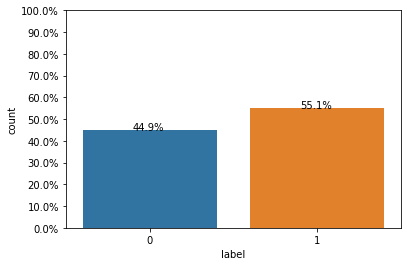

In [5]:
total = len(train_data)*1.
ax=sns.countplot(x="label", data=train_data)
for p in ax.patches:
    print(p)
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.3, p.get_height()+5))

#on y axis  from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))
print(ax.yaxis.get_majorticklocs())
# with out changing the position converting to percentage on y axis without changing the positions. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

# Data Preprocessing

## Features

In [6]:
# description of all features
data_features =pd.read_csv(FEATURE_DATASET_PATH, sep=",", encoding='cp1252')
print(data_features.shape)
data_features.head(49)

(49, 4)


,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [7]:
# categorical features
cat_feature = train_data.select_dtypes(include=['category', object]).columns
cat_feature

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')

In [8]:
# understaing of numerical features/data/variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = train_data.drop(['id','label'], axis=1).select_dtypes(include=numerics).columns
num_features

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

## Dropping Highly Relevant Features

### Feature Correlation

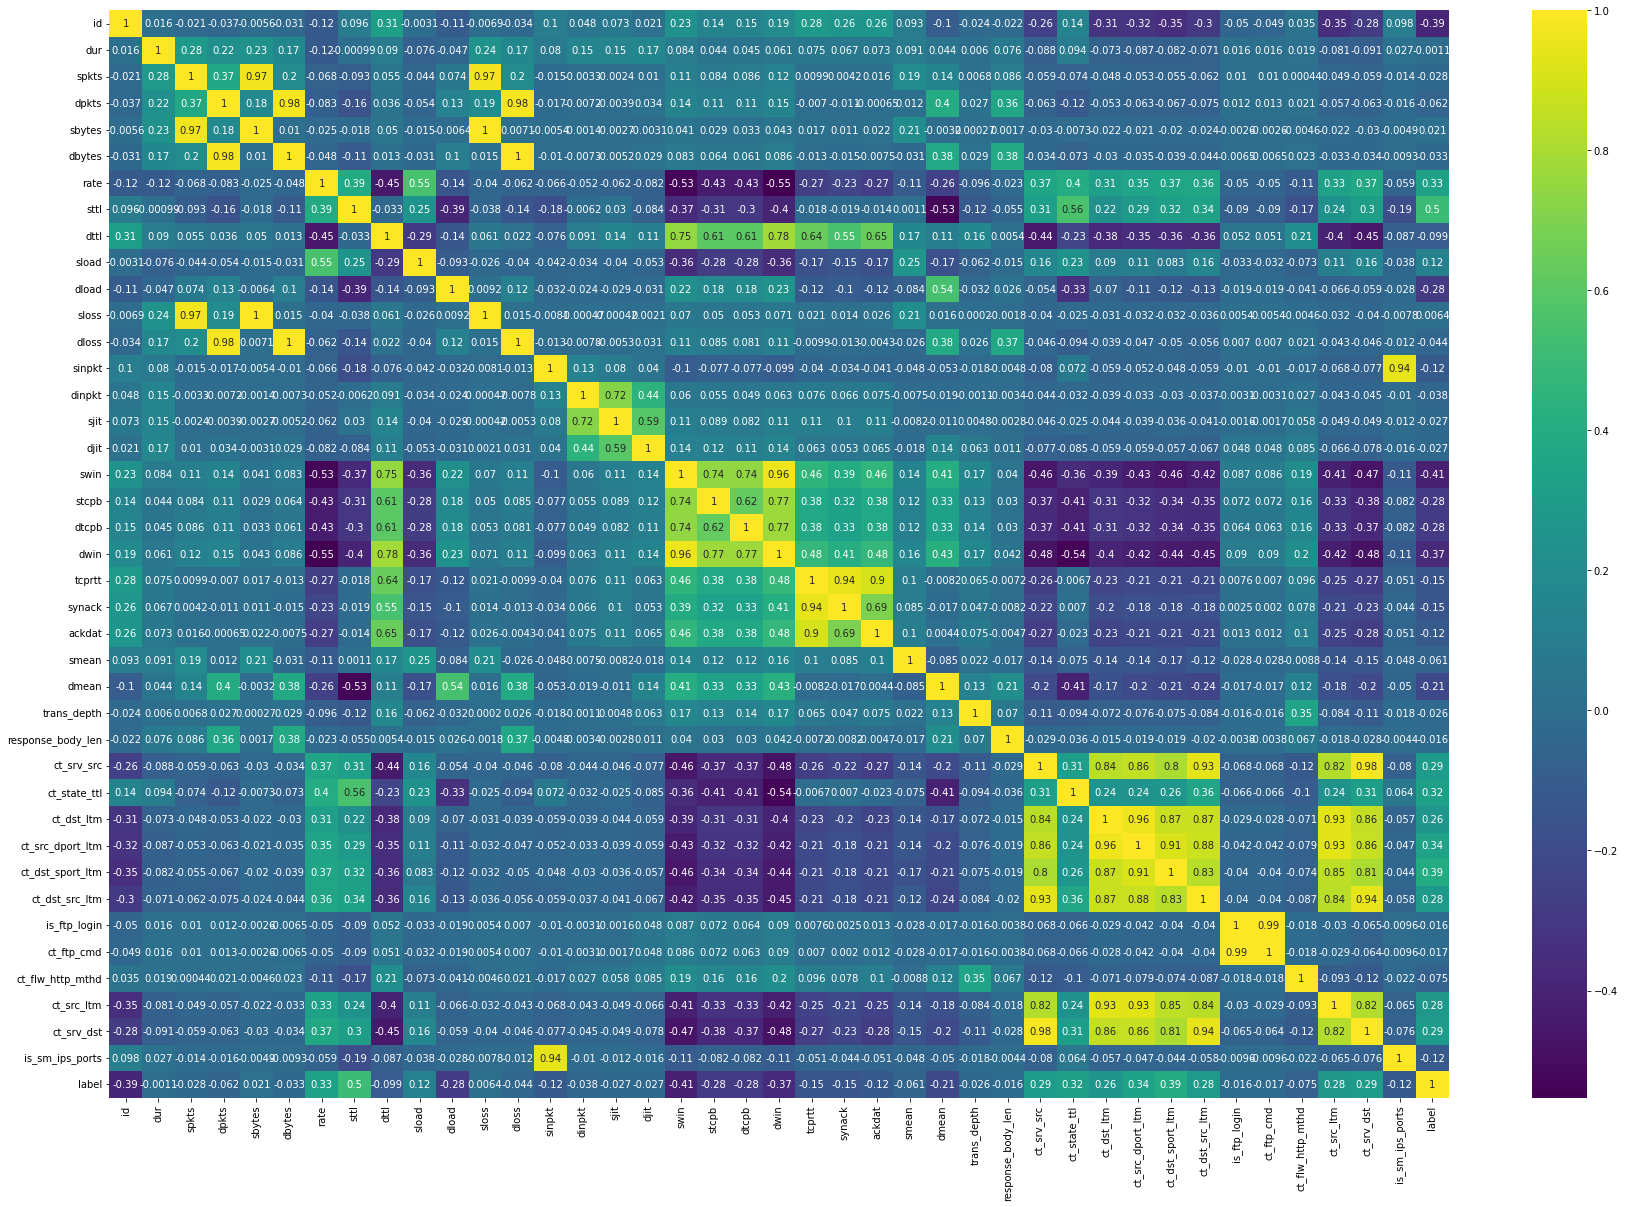

In [9]:
# from the above graphs while understanding the density of numerical data  we see there is high corelation for certain features. 
# we shall find the highly corelated data and drop the columns to avoid overhead 
df_corr = train_data.corr()

plt.figure(figsize=(30,20))
sns.heatmap(df_corr, annot=True, cmap=plt.cm.viridis)
plt.savefig('figures/correlation_matrix.png')
plt.show()

### Drop Features Correlation Above 0.95

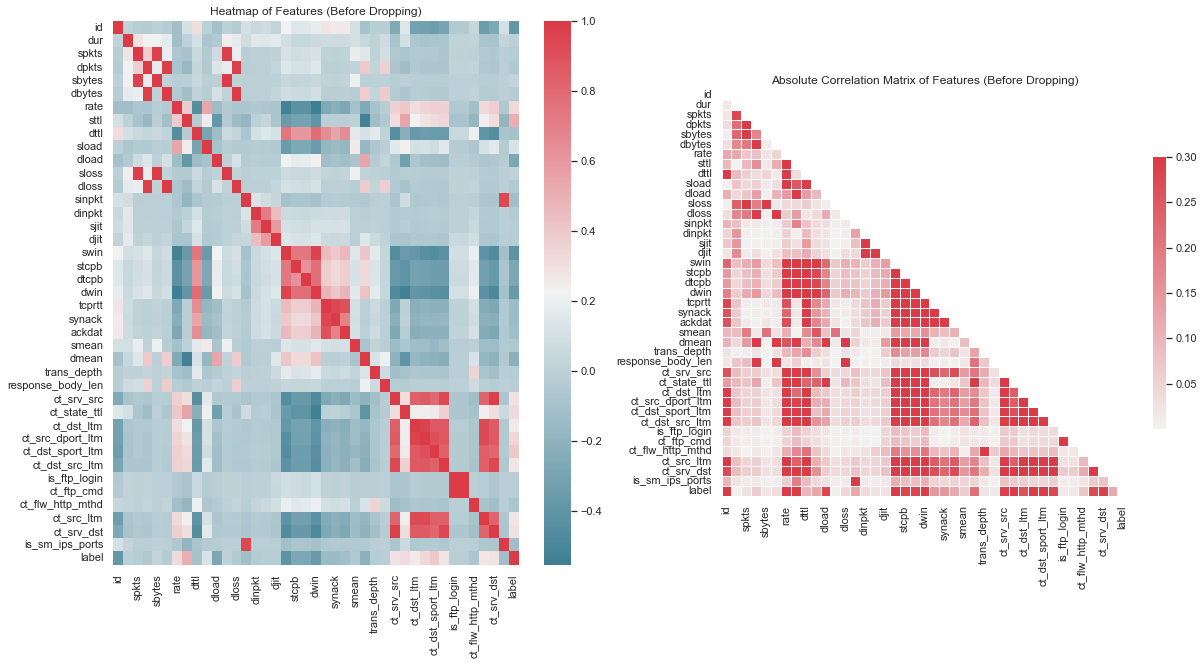

In [10]:
from utils.graph_utils import *
fig_name = "figures/cor_matrix"
visualize_cor_matrix(fig_name, train_data)

In [11]:
# we shall find the correlation above 0.95 andn shall drop the columns to avoid overhead  
high_corr_var=np.where(df_corr>0.95)
high_corr_var
# for x,y in zip(*high_corr_var):  解包操作符（unpacking operator）
#     print(x, y)
#calculate correlation betweena ll columns and remove highly correlated one
high_corr_var_pairs=[(df_corr.columns[x],df_corr.columns[y]) 
               for x,y in zip(*high_corr_var)
               if x!=y and x<y]
high_corr_var_pairs

[('spkts', 'sbytes'),
 ('spkts', 'sloss'),
 ('dpkts', 'dbytes'),
 ('dpkts', 'dloss'),
 ('sbytes', 'sloss'),
 ('dbytes', 'dloss'),
 ('swin', 'dwin'),
 ('ct_srv_src', 'ct_srv_dst'),
 ('ct_dst_ltm', 'ct_src_dport_ltm'),
 ('is_ftp_login', 'ct_ftp_cmd')]

In [12]:
# Remove highly correlated features
corr_matrix = train_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
train_data = train_data.drop(to_drop, axis=1)

# Print summary of dropped features
print(f"Dropped {len(to_drop)} highly correlated features:")
for feature in to_drop:
    print(f"- {feature}")
    
# Print summary of remaining features
print(f"\n{len(train_data.columns)} features remaining:")
print(train_data.columns.tolist())


Dropped 8 highly correlated features:
- sbytes
- dbytes
- sloss
- dloss
- dwin
- ct_src_dport_ltm
- ct_ftp_cmd
- ct_srv_dst

37 features remaining:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_flw_http_mthd', 'ct_src_ltm', 'is_sm_ips_ports', 'attack_cat', 'label']


## Feature Mapping （category to numarical）

In [13]:
#lets find any catagorial data and lable it usinng lable encoder  with out disturbing the shape/dimentions
cat_feature = train_data.select_dtypes(include=['category', object]).columns
cat_feature

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')

In [14]:
from sklearn.preprocessing import LabelEncoder
train_data[cat_feature] = train_data[cat_feature].apply(LabelEncoder().fit_transform)
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,...,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,90909.0902,254,0,...,2,1,1,2,0,0,1,0,6,0
1,2,0.000008,117,0,4,2,0,125000.0003,254,0,...,2,1,1,2,0,0,1,0,6,0
2,3,0.000005,117,0,4,2,0,200000.0051,254,0,...,2,1,1,3,0,0,1,0,6,0
3,4,0.000006,117,0,4,2,0,166666.6608,254,0,...,2,2,1,3,0,0,2,0,6,0
4,5,0.000010,117,0,4,2,0,100000.0025,254,0,...,2,2,1,3,0,0,2,0,6,0


## filter for feature selection ( chi-square)
Filter methods are generally used as a **preprocessing step**. So it can also be called static method. In this method, the model starts with all features and selects the best features subset based on statistical measures.<br>
Filter methods consists of various techniques as given below:

   -  1 Basic methods
   -  2  Univariate feature selection
   - 3 Information gain
   -  4 Fischer score
   -  5 NOVA F-Value for Feature Selection
   -  6 Correlation Matrix with Heatmap 
   
chi-square implementation (Fischer score): computes **chi-squared stats** between each non-negative feature and class.

In [15]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel, RFE

X_train = train_data.iloc[:, 1:-2]
y_train = train_data['label']
column_names = X_train.columns.tolist()

skb = SelectKBest(chi2, k=27)
X_train = skb.fit_transform(X_train, y_train)
indices = skb.get_support(indices=True)
select_column_names = [column_names[i] for i in indices]
X_train = pd.DataFrame(X_train, columns=select_column_names)
X_train

,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,...,dmean,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports
0,0.0,4.0,2.0,0.0,90909.090200,254.0,0.0,1.803636e+08,0.000000,0.011000,...,0.0,0.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0
1,0.0,4.0,2.0,0.0,125000.000300,254.0,0.0,8.810000e+08,0.000000,0.008000,...,0.0,0.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0
2,0.0,4.0,2.0,0.0,200000.005100,254.0,0.0,8.544000e+08,0.000000,0.005000,...,0.0,0.0,3.0,2.0,1.0,1.0,3.0,0.0,1.0,0.0
3,0.0,4.0,2.0,0.0,166666.660800,254.0,0.0,6.000000e+08,0.000000,0.006000,...,0.0,0.0,3.0,2.0,2.0,1.0,3.0,0.0,2.0,0.0
4,0.0,4.0,2.0,0.0,100000.002500,254.0,0.0,8.504000e+08,0.000000,0.010000,...,0.0,0.0,3.0,2.0,2.0,1.0,3.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.0,4.0,2.0,0.0,200000.005100,254.0,0.0,8.320000e+07,0.000000,0.005000,...,0.0,0.0,1.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0
82328,0.0,3.0,20.0,8.0,24.410067,254.0,252.0,1.241044e+05,2242.109863,55.880051,...,44.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,3.0,0.0
82329,0.0,4.0,1.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000,60000.720000,...,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0
82330,0.0,4.0,1.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000,60000.732000,...,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0


In [16]:
with open("txts/feature_selected.txt", "w") as file:
    file.write(str(select_column_names))

# ML Process

## Construct Dataset with Selected Features

Prepare Extracted train data  from Original Data D

2.1. Using the rules repository R obtained in step 1.3, 
extract the relevant features from the Original Data D and 
create a new Train data D' containing only these features.

In [18]:
train_data = pd.read_csv("../dataset/used/UNSW_NB15_training-set.csv")
test_data = pd.read_csv("../dataset/used/UNSW_NB15_testing-set.csv")
cat_feature = train_data.select_dtypes(include=['category', object]).columns
train_data[cat_feature] = train_data[cat_feature].apply(LabelEncoder().fit_transform)
test_data[cat_feature] = test_data[cat_feature].apply(LabelEncoder().fit_transform)
df_train = train_data[select_column_names]
df_test = test_data[select_column_names]

In [19]:
df_train

,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,...,dmean,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports
0,0,4,2,0,90909.090200,254,0,1.803636e+08,0.000000,0.011000,...,0,0,2,2,1,1,2,0,1,0
1,0,4,2,0,125000.000300,254,0,8.810000e+08,0.000000,0.008000,...,0,0,2,2,1,1,2,0,1,0
2,0,4,2,0,200000.005100,254,0,8.544000e+08,0.000000,0.005000,...,0,0,3,2,1,1,3,0,1,0
3,0,4,2,0,166666.660800,254,0,6.000000e+08,0.000000,0.006000,...,0,0,3,2,2,1,3,0,2,0
4,0,4,2,0,100000.002500,254,0,8.504000e+08,0.000000,0.010000,...,0,0,3,2,2,1,3,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0,4,2,0,200000.005100,254,0,8.320000e+07,0.000000,0.005000,...,0,0,1,2,2,1,2,0,2,0
82328,0,3,20,8,24.410067,254,252,1.241044e+05,2242.109863,55.880051,...,44,0,1,1,2,1,1,0,3,0
82329,0,4,1,0,0.000000,0,0,0.000000e+00,0.000000,60000.720000,...,0,0,1,2,1,1,1,0,1,1
82330,0,4,1,0,0.000000,0,0,0.000000e+00,0.000000,60000.732000,...,0,0,1,2,1,1,1,0,1,1


In [20]:
df_test

,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,...,dmean,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports
0,0,2,6,4,74.087490,252,254,1.415894e+04,8495.365234,24.295600,...,43,0,1,0,1,1,1,0,1,0
1,0,2,14,38,78.473372,62,252,8.395112e+03,503571.312500,49.915000,...,1106,0,43,1,1,1,2,0,1,0
2,0,2,8,16,14.170161,62,252,1.572272e+03,60929.230470,231.875571,...,824,0,7,1,2,1,3,0,2,0
3,3,2,12,12,13.677108,62,252,2.740179e+03,3358.622070,152.876547,...,64,0,1,1,2,1,3,0,2,0
4,0,2,10,6,33.373826,254,252,8.561499e+03,3987.059814,47.750333,...,45,0,43,1,2,1,40,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,2,3,2,0,111111.107200,254,0,5.066666e+07,0.000000,0.009000,...,0,0,24,2,24,13,24,0,24,0
175337,0,2,10,8,33.612649,254,252,8.826286e+03,4903.492188,54.400111,...,44,0,1,1,1,1,2,0,1,0
175338,2,3,2,0,111111.107200,254,0,5.066666e+07,0.000000,0.009000,...,0,0,12,2,3,3,13,0,3,0
175339,2,3,2,0,111111.107200,254,0,5.066666e+07,0.000000,0.009000,...,0,0,30,2,30,14,30,0,30,0


Train the Machine and Standardize the data

4.1. Train a machine learning model on the preprocessed D' obtained in step 2.1.

In [21]:
from sklearn import preprocessing
x = df_train.values
x_test = df_test.values
std_scaler = preprocessing.MinMaxScaler()
std_scaler.fit(x)
x_scaled = std_scaler.transform(x)
df_train = pd.DataFrame(x_scaled)
x_scaled_test = std_scaler.transform(x_test)
df_test = pd.DataFrame(x_scaled_test)

In [22]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,0.666667,0.000094,0.0,0.090909,0.996078,0.0,0.034238,0.0,1.833028e-07,...,0.0,0.0,0.016129,0.333333,0.000000,0.0,0.016129,0.0,0.000000,0.0
1,0.0,0.666667,0.000094,0.0,0.125000,0.996078,0.0,0.167236,0.0,1.333111e-07,...,0.0,0.0,0.016129,0.333333,0.000000,0.0,0.016129,0.0,0.000000,0.0
2,0.0,0.666667,0.000094,0.0,0.200000,0.996078,0.0,0.162187,0.0,8.331946e-08,...,0.0,0.0,0.032258,0.333333,0.000000,0.0,0.032258,0.0,0.000000,0.0
3,0.0,0.666667,0.000094,0.0,0.166667,0.996078,0.0,0.113895,0.0,9.998335e-08,...,0.0,0.0,0.032258,0.333333,0.017241,0.0,0.032258,0.0,0.016949,0.0
4,0.0,0.666667,0.000094,0.0,0.100000,0.996078,0.0,0.161427,0.0,1.666389e-07,...,0.0,0.0,0.032258,0.333333,0.017241,0.0,0.032258,0.0,0.016949,0.0


In [23]:
y_train = train_data['label']
y_test = test_data['label']
print("train data shape", df_train.shape, y_train.shape)
print("test data shape", df_test.shape, y_test.shape)

train data shape (82332, 27) (82332,)
test data shape (175341, 27) (175341,)


Apply Classification

5.1. Using the trained machine learning model, classify the preprocessed live data obtained in step 3.1.

Print Accuracy

6.1. Evaluate the accuracy of the classification model on the live data using appropriate metrics such 
as accuracy, precision, recall, and F1-score.

In [24]:
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer

import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

## Logistic Regression Model

In [25]:
#Logistic Regression Model
prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
lr_cfl=GridSearchCV(SGDClassifier(penalty='l2', loss='log', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
lr_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(estimator=SGDClassifier(loss='log', n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [26]:
results = pd.DataFrame.from_dict(lr_cfl.cv_results_)
results = results.sort_values(['rank_test_score'])
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.538159,0.055810,0.023539,0.007837,0.0001,1,5,"{'alpha': 0.0001, 'eta0': 1, 'max_iter': 5}",0.899496,0.960406,0.853273,0.782764,0.751124,0.849413,0.076086,1
12,0.812826,0.082956,0.018349,0.008479,0.0001,0.01,20,"{'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 20}",0.894456,0.954819,0.854124,0.763695,0.754282,0.844275,0.076716,2
7,0.835170,0.058817,0.018150,0.009194,0.0001,0.001,20,"{'alpha': 0.0001, 'eta0': 0.001, 'max_iter': 20}",0.882796,0.950507,0.843313,0.781489,0.750698,0.841761,0.071326,3
22,0.955448,0.079971,0.017552,0.006954,0.0001,1,20,"{'alpha': 0.0001, 'eta0': 1, 'max_iter': 20}",0.886925,0.949839,0.858982,0.757804,0.753917,0.841494,0.075871,4
17,0.846333,0.059475,0.024335,0.011574,0.0001,0.1,20,"{'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 20}",0.887776,0.942612,0.861776,0.779849,0.735273,0.841457,0.074648,5


In [27]:
print(lr_cfl.best_params_)

{'alpha': 0.0001, 'eta0': 1, 'max_iter': 5}


In [28]:
logisticR=SGDClassifier(alpha=lr_cfl.best_params_['alpha'],eta0=lr_cfl.best_params_['eta0'], penalty='l2', loss='log', n_jobs = -1, max_iter=lr_cfl.best_params_['max_iter'])
logisticR.fit(df_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(df_train, y_train)
predict_y_tr_lr = sig_clf.predict(df_train)
predict_y_te_lr = sig_clf.predict(df_test)
lr_f1 = f1_score(y_test, predict_y_te_lr)
print(lr_f1)

0.7264331210191083


In [29]:
cm_lr = confusion_matrix(y_test, predict_y_te_lr)

In [30]:
tn, fp, fn, tp = cm_lr.ravel()

In [31]:
fpr_lr = fp/(fp+tn)*100
fnr_lr = fn/(fn+tp)*100
far_lr = (fpr_lr+fnr_lr)/2
print("FAR: %0.2f" %far_lr)

FAR: 21.89


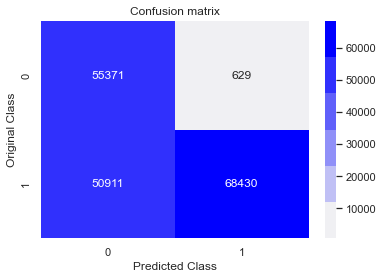

In [32]:
plot_cm(cm_lr)

AUC_LR:  0.7810833864274881


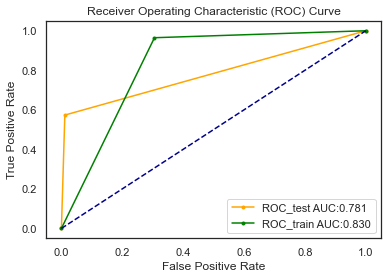

In [33]:
#finding the FPR and TPR for logistic reg model set
fpr_te_lr, tpr_te_lr, t_te_lr = roc_curve(y_test, predict_y_te_lr)
fpr_tr_lr, tpr_tr_lr, t_tr_lr = roc_curve(y_train, predict_y_tr_lr)
auc_te_lr = auc(fpr_te_lr, tpr_te_lr)
print("AUC_LR: ",auc_te_lr)
plot_roc_curve(fpr_tr_lr,tpr_tr_lr,fpr_te_lr, tpr_te_lr)

## Support Vector Machine Model 

In [34]:
# Support Vector Machine Model 

prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
svm_cfl=GridSearchCV(SGDClassifier(penalty='l1', loss='hinge', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
svm_cfl.fit(df_train,y_train)


Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(estimator=SGDClassifier(n_jobs=-1, penalty='l1'), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [35]:
print(svm_cfl.best_params_)

{'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 5}


In [36]:
svm=SGDClassifier(alpha=svm_cfl.best_params_['alpha'],eta0=svm_cfl.best_params_['eta0'], penalty='l2', loss='hinge', n_jobs = -1, max_iter=svm_cfl.best_params_['max_iter'])
svm.fit(df_train,y_train)
sig_clf_svm = CalibratedClassifierCV(svm, method="sigmoid")
sig_clf_svm.fit(df_train, y_train)
predict_y_tr_svm = sig_clf.predict(df_train)
predict_y_te_svm = sig_clf_svm.predict(df_test)
svm_f1 = f1_score(y_test, predict_y_te_svm)
print("F1-Score", svm_f1)

F1-Score 0.7519865557376709


In [37]:
cm_svm = confusion_matrix(y_test, predict_y_te_svm)

In [38]:
tn, fp, fn, tp = cm_svm.ravel()

In [39]:
fpr_svm = fp/(fp+tn)*100
fnr_svm = fn/(fn+tp)*100
far_svm = (fpr_svm+fnr_svm)/2
print("FAR: %0.2f" % far_svm)

FAR: 20.49


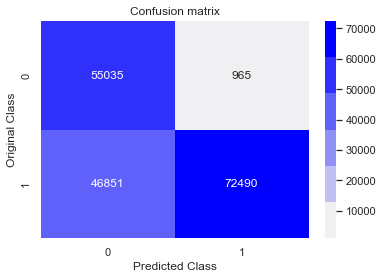

In [40]:
plot_cm(cm_svm)

AUC_SVM:  0.7950934667854539


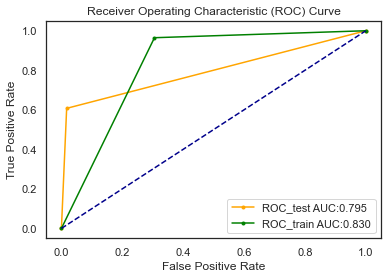

In [41]:
#finding the FPR and TPR for SVM set
fpr_te_svm, tpr_te_svm, t_te_svm = roc_curve(y_test, predict_y_te_svm)
fpr_tr_svm, tpr_tr_svm, t_tr_svm = roc_curve(y_train, predict_y_tr_svm)
auc_te_svm = auc(fpr_te_svm, tpr_te_svm)
print("AUC_SVM: ",auc_te_svm)
plot_roc_curve(fpr_tr_svm,tpr_tr_svm,fpr_te_svm, tpr_te_svm)

## Random Forest Model

In [42]:
# Random Forest Model
# param_grid = {"n_estimators": [10,100,500,1000, 2000],
#     "min_samples_split": [50, 80, 120, 200],
#               "max_depth": [3, 5, 10, 50, 100]}
# rfc = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1)
# gridCV_rfc = GridSearchCV(rfc, param_grid, cv=3, return_train_score=True, verbose=10, n_jobs=-1)
# gridCV_rfc.fit(df_train, y_train)
# #grid Search cv results are stored in result for future use
# results_rfc = pd.DataFrame.from_dict(gridCV_rfc.cv_results_)

In [43]:
# results_rfc = results_rfc.sort_values(['rank_test_score'])
# results_rfc.head()

In [44]:
# print(gridCV_rfc.best_params_)

In [45]:
# rfc= RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=gridCV_rfc.best_params_['max_depth'],min_samples_split=gridCV_rfc.best_params_['min_samples_split'], n_estimators=gridCV_rfc.best_params_['n_estimators'])
# rfc.fit(df_train,y_train)
# sig_clf_rfc = CalibratedClassifierCV(rfc, method="sigmoid")
# sig_clf_rfc.fit(df_train, y_train)
# predict_y_tr_rfc = sig_clf_rfc.predict(df_train)
# predict_y_te_rfc = sig_clf_rfc.predict(df_test)
# rfc_f1 = f1_score(y_test, predict_y_te_rfc)
# print(rfc_f1)

In [46]:
# cm_rfc = confusion_matrix(y_test, predict_y_te_rfc)

In [47]:
# tn, fp, fn, tp = cm_rfc.ravel()

In [48]:
# fpr_rfc = fp/(fp+tn)*100
# fnr_rfc = fn/(fn+tp)*100
# far_rfc = (fpr_rfc+fnr_rfc)/2
# print("far:",far_rfc)

In [49]:
# plot_cm(cm_rfc)

In [50]:
#finding the FPR and TPR for RFC set
# fpr_te_rfc, tpr_te_rfc, t_te_rfc = roc_curve(y_test, predict_y_te_rfc)
# fpr_tr_rfc, tpr_tr_rfc, t_tr_rfc = roc_curve(y_train, predict_y_tr_rfc)
# auc_te_rfc = auc(fpr_te_rfc, tpr_te_rfc)
# print("AUC_RFC: ",auc_te_rfc)
# plot_roc_curve(fpr_tr_rfc,tpr_tr_rfc,fpr_te_rfc, tpr_te_rfc)

## Stacking Classifier with (LR,SVM, RF)

In [51]:
# Stacking classifier

clf1 = SGDClassifier(alpha=0.0001,eta0=0.001, penalty='l2', loss='log', n_jobs = -1, max_iter=100)
clf1.fit(df_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001,eta0=0.01, penalty='l2', loss='hinge', n_jobs = -1, max_iter=100)
clf2.fit(df_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=50,min_samples_split=50, n_estimators=2000)
clf3.fit(df_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

In [52]:
# alpha = [0.0001,0.001,0.01,0.1,1,10] 
# best_alpha = 999
# for i in alpha:
#     lr = LogisticRegression(C=i)
#     sclf = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
#     sclf.fit(df_train, y_train)
#     print("Stacking Classifer : for the value of alpha: %f Log loss: %0.3f F1-score: %0.3f" % (i, log_loss(y_test, sclf.predict_proba(df_test)),f1_score(y_test, sclf.predict(df_test))))
#     log_error =log_loss(y_test, sclf.predict_proba(df_test))
#     if best_alpha > log_error:
#         best_alpha = log_error

In [53]:
lr = LogisticRegression(C=10)
sig_clf_sc = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
sig_clf_sc.fit(df_train, y_train)
predict_y_tr_sc= sig_clf_sc.predict(df_train)
predict_y_te_sc = sig_clf_sc.predict(df_test)
sc_f1 = f1_score(y_test, predict_y_te_sc)
print(sc_f1)

0.9286062313409698


In [54]:
cm_sc = confusion_matrix(y_test, predict_y_te_sc)

In [55]:
tn, fp, fn, tp = cm_sc.ravel()

In [56]:
fpr_sc = fp/(fp+tn)*100
fnr_sc = fn/(fn+tp)*100
far_sc = (fpr_sc+fnr_sc)/2
print("far:",far_sc)

far: 7.510667653135612


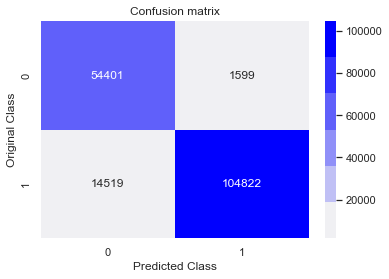

In [57]:
plot_cm(cm_sc)

AUC_SC:  0.924893323468644


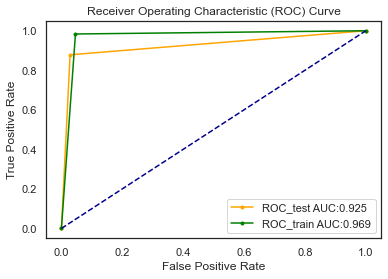

In [58]:
#finding the FPR and TPR for RFC set
fpr_te_sc, tpr_te_sc, t_te_sc = roc_curve(y_test, predict_y_te_sc)
fpr_tr_sc, tpr_tr_sc, t_tr_sc = roc_curve(y_train, predict_y_tr_sc)
auc_te_sc = auc(fpr_te_sc, tpr_te_sc)
print("AUC_SC: ",auc_te_sc)
plot_roc_curve(fpr_tr_sc,tpr_tr_sc,fpr_te_sc, tpr_te_sc)

## AdaBoost classifier with Decision Tree

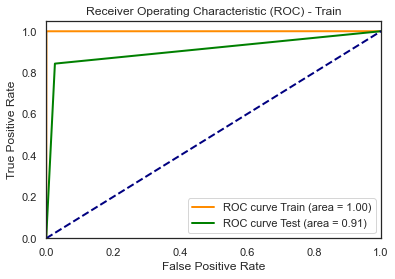

In [59]:


ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
ada.fit(df_train, y_train)
y_pred_train = ada.predict(df_train)
y_pred_test = ada.predict(df_test)
# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
# F1 score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
# ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
roc_auc_train1 = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_test1 = auc(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve Train (area = %0.2f)' % roc_auc_train1)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve Test (area = %0.2f)' % roc_auc_test1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train')
plt.legend(loc="lower right")
plt.show()

In [60]:
ada_f1 = f1_score(y_test, y_pred_test)
print(ada_f1)

0.9090999399448215


In [61]:
cm_ada = confusion_matrix(y_test, y_pred_test)

In [62]:
tn, fp, fn, tp = cm_ada.ravel()

In [63]:
fpr_ada = fp/(fp+tn)*100
fnr_ada = fn/(fn+tp)*100
far_ada = (fpr_ada+fnr_ada)/2
print("far:",far_ada)

far: 9.124217997167781


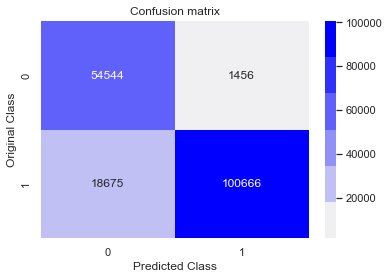

In [64]:
plot_cm(cm_ada)

## Ensemble with SVM

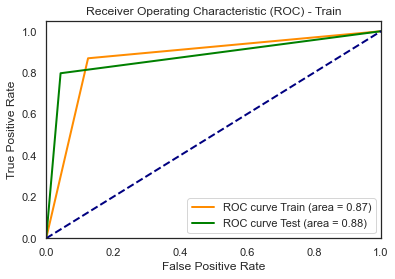

In [65]:
#Ensemble with SVM
# Initialize the SVM models
svm1 = SVC(kernel='linear', C=1)
svm2 = SVC(kernel='rbf', gamma=0.1, C=1)
svm3 = SVC(kernel='poly', degree=3, C=1)

# Initialize the voting classifier
ensemble = VotingClassifier(estimators=[('linear', svm1), ('rbf', svm2), ('poly', svm3)], voting='hard')

# Train the ensemble model
ensemble.fit(df_train, y_train)

# Make predictions on the test set
y_pred_train = ensemble.predict(df_train)
y_pred_test = ensemble.predict(df_test)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
# F1 score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
# ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve Train (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve Test (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train')
plt.legend(loc="lower right")
plt.show()

In [66]:
en_svm_f1 = f1_score(y_test, y_pred_test)
print(en_svm_f1)

0.8772392550341451


In [67]:
cm_en_svm = confusion_matrix(y_test, y_pred_test)

In [68]:
tn, fp, fn, tp = cm_en_svm.ravel()

In [69]:
fpr_en_svm = fp/(fp+tn)*100
fnr_en_svm = fn/(fn+tp)*100
far_en_svm = (fpr_en_svm+fnr_en_svm)/2
print("far:",far_en_svm)

far: 12.293876258847694


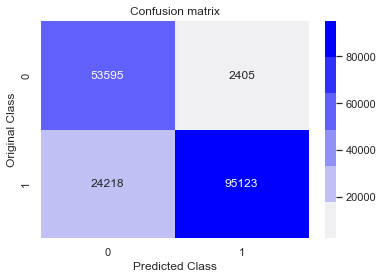

In [70]:
plot_cm(cm_en_svm)

## XGBoost classifier (ext of GBoost )

Accuracy: 0.903279894605369


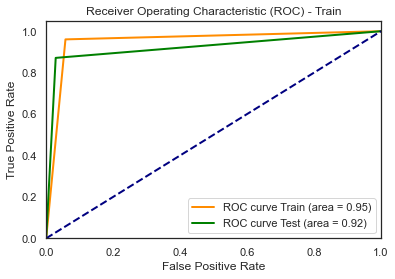

In [71]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# Train the model
xgb_model.fit(df_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(df_test)

# Evaluate the accuracy of the model
accuracy = xgb_model.score(df_test, y_test)
print("Accuracy:", accuracy)


# Make predictions on the test set
y_pred_train = xgb_model.predict(df_train)
y_pred_test = xgb_model.predict(df_test)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
# F1 score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
# ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
xg_roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
xg_roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve Train (area = %0.2f)' % xg_roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve Test (area = %0.2f)' % xg_roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train')
plt.legend(loc="lower right")
plt.show()



In [72]:
xg_f1 = f1_score(y_test, y_pred_test)
print(xg_f1)

0.9245934878012994


In [73]:
cm_xg = confusion_matrix(y_test, y_pred_test)

In [74]:
tn, fp, fn, tp = cm_xg.ravel()

In [75]:
fpr_xg = fp/(fp+tn)*100
fnr_xg = fn/(fn+tp)*100
far_xg = (fpr_xg+fnr_xg)/2
print("far:",far_xg)

far: 7.858280421229921


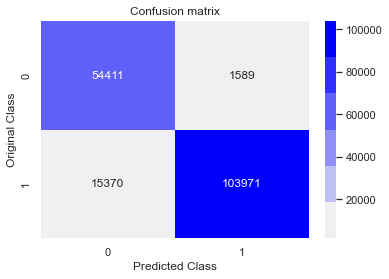

In [76]:
plot_cm(cm_xg)

## Gradient Boosting classifier

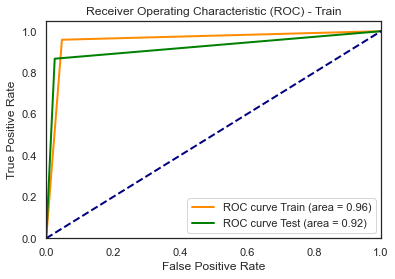

In [77]:
# Create the Gradient Boosting classifier object
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# Train the classifier on the training data
clf.fit(df_train, y_train)

# Make predictions on the test set
y_pred_train = clf.predict(df_train)
y_pred_test = clf.predict(df_test)

# Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
# F1 score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

# ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
clf_roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
clf_roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve Train (area = %0.2f)' % clf_roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve Test (area = %0.2f)' % clf_roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train')
plt.legend(loc="lower right")
plt.show()


In [78]:
clf_f1 = f1_score(y_test, y_pred_test)
print(clf_f1)

0.9229767632671444


In [79]:
cm_clf = confusion_matrix(y_test, y_pred_test)

In [80]:
tn, fp, fn, tp = cm_clf.ravel()

In [81]:
fpr_clf = fp/(fp+tn)*100
fnr_clf = fn/(fn+tp)*100
far_clf = (fpr_clf+fnr_clf)/2
print("far:",far_clf)

far: 7.911644423482769


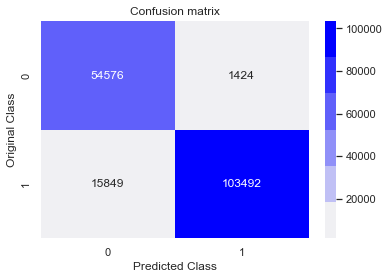

In [82]:
plot_cm(cm_clf)

# Model Evaluation

In [83]:
#Model Evaluation
import prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "F1 Score", "AUC","FPR %","FNR %","FAR %"]
#x.add_row(["Logistic Regression", "{0:.4}".format(lr_f1), "{0:.4}".format(auc_te_lr),"%.2f" % float(fpr_lr),"%.2f" % float(fnr_lr),"%.2f" % float(far_lr)])
#x.add_row(["Linear SVM", "{0:.4}".format(svm_f1), "{0:.4}".format(auc_te_svm),"%.2f" % float(fpr_svm),"%.2f" % float(fnr_svm),"%.2f" % float(far_svm)])
#x.add_row(["Random Forest", "{0:.4}".format(rfc_f1), "{0:.4}".format(auc_te_rfc),"%.2f" % float(fpr_rfc),"%.2f" % float(fnr_rfc),"%.2f" % float(far_rfc)])
x.add_row(["Stacking Classifier with (LR,SVM, RF)", "{0:.4}".format(sc_f1), "{0:.4}".format(auc_te_sc),"%.2f" % float(fpr_sc),"%.2f" % float(fnr_sc),"%.2f" % float(far_sc)])
x.add_row(["Ensemble with SVM", "{0:.4}".format(en_svm_f1), "{0:.4}".format(roc_auc_test),"%.2f" % float(fpr_en_svm),"%.2f" % float(fnr_en_svm),"%.2f" % float(far_en_svm)])
x.add_row(["AdaBoost classifier with Decision Tree", "{0:.4}".format(ada_f1), "{0:.4}".format(roc_auc_test1),"%.2f" % float(fpr_ada),"%.2f" % float(fnr_ada),"%.2f" % float(far_ada)])
x.add_row(["Gradient Boosting classifier", "{0:.4}".format(clf_f1), "{0:.4}".format(clf_roc_auc_test),"%.2f" % float(fpr_clf),"%.2f" % float(fnr_clf),"%.2f" % float(far_clf)])
x.add_row(["XGBoost classifier (ext of GBoost )", "{0:.4}".format(xg_f1), "{0:.4}".format(xg_roc_auc_test),"%.2f" % float(fpr_xg),"%.2f" % float(fnr_xg),"%.2f" % float(far_xg)])
print(x)

+----------------------------------------+----------+--------+-------+-------+-------+
|                 Model                  | F1 Score |  AUC   | FPR % | FNR % | FAR % |
+----------------------------------------+----------+--------+-------+-------+-------+
| Stacking Classifier with (LR,SVM, RF)  |  0.9286  | 0.9249 |  2.86 | 12.17 |  7.51 |
|           Ensemble with SVM            |  0.8772  | 0.8771 |  4.29 | 20.29 | 12.29 |
| AdaBoost classifier with Decision Tree |  0.9091  | 0.9088 |  2.60 | 15.65 |  9.12 |
|      Gradient Boosting classifier      |  0.923   | 0.9209 |  2.54 | 13.28 |  7.91 |
|  XGBoost classifier (ext of GBoost )   |  0.9246  | 0.9214 |  2.84 | 12.88 |  7.86 |
+----------------------------------------+----------+--------+-------+-------+-------+


In [84]:
import csv

table_data = [
    ["Model", "F1 Score", "AUC", "FPR %", "FNR %", "FAR %"],
    ["Stacking Classifier with (LR,SVM, RF)", "{0:.4}".format(sc_f1), "{0:.4}".format(auc_te_sc), "%.2f" % float(fpr_sc), "%.2f" % float(fnr_sc), "%.2f" % float(far_sc)],
    ["Ensemble with SVM", "{0:.4}".format(en_svm_f1), "{0:.4}".format(roc_auc_test), "%.2f" % float(fpr_en_svm), "%.2f" % float(fnr_en_svm), "%.2f" % float(far_en_svm)],
    ["AdaBoost classifier with Decision Tree", "{0:.4}".format(ada_f1), "{0:.4}".format(roc_auc_test1), "%.2f" % float(fpr_ada), "%.2f" % float(fnr_ada), "%.2f" % float(far_ada)],
    ["Gradient Boosting classifier", "{0:.4}".format(clf_f1), "{0:.4}".format(clf_roc_auc_test), "%.2f" % float(fpr_clf), "%.2f" % float(fnr_clf), "%.2f" % float(far_clf)],
    ["XGBoost classifier (ext of GBoost )", "{0:.4}".format(xg_f1), "{0:.4}".format(xg_roc_auc_test), "%.2f" % float(fpr_xg), "%.2f" % float(fnr_xg), "%.2f" % float(far_xg)]
]

csv_file_path = "csvs/model_evaluation.csv"

with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(table_data)

print(f"Data has been written to {csv_file_path}")


Data has been written to csvs/model_evaluation.csv
